In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#import seaborn as sns
from matplotlib import pyplot as plt
#%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
import joblib

In [3]:
hist_ship_df = pd.read_csv('perm_feat_imp_example.csv')
hist_ship_df.head()

,plant_country,plant_state,plant_city,plant_zip3,plant_zip,ship_to_country,ship_to_state,ship_to_city,ship_to_zip3,ship_to_zip,weight_in_sto,distance_in_miles,total_cost_usd
0,1132.85986,1411.949564,1411.949564,1411.949564,1411.949564,920.887836,610.130136,1251.045865,1257.920638,1265.347328,24.442622,264.704128,1209.9225
1,1132.85986,1411.949564,1411.949564,1411.949564,1411.949564,920.887836,610.130136,1251.045865,1257.920638,1265.347328,24.289401,264.704128,1072.6500
2,1132.85986,1411.949564,1411.949564,1411.949564,1411.949564,920.887836,610.130136,1251.045865,1257.920638,1265.347328,24.542932,264.704128,1072.6500
3,1132.85986,1411.949564,1411.949564,1411.949564,1411.949564,920.887836,610.130136,1251.045865,1257.920638,1265.347328,24.853784,264.704128,1072.6500
4,1132.85986,1411.949564,1411.949564,1411.949564,1411.949564,920.887836,610.130136,1251.045865,1257.920638,1265.347328,24.933150,264.704128,1072.6500


In [4]:
columns_to_select = list(set(hist_ship_df.columns) - {'total_cost_usd'})
x = hist_ship_df[columns_to_select].values
y = hist_ship_df['total_cost_usd'].values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, stratify=None)

In [6]:
# Complex model training and hyperparameter tuning :)
model = LGBMRegressor().fit(x_train, y_train)

In [7]:
train_error = mse(model.predict(x_train), y_train)
test_error = mse(model.predict(x_test), y_test)
train_error, test_error

(47819.58314093501, 51198.23568801152)

In [8]:
def calculate_metric(y_true, y_hat):
    return ((y_true - y_hat) ** 2).mean()

def permutation_feature_importance(model, x, y, cols, num_iterations=10):
    perm_mse_dict = {}
    for feature_num in range(len(cols)):
        for i in range(num_iterations):
            permuted_inds = np.random.RandomState(seed=i).permutation(x.shape[0])
            x_perm = np.copy(x)
            x_perm[:, feature_num] = x_perm[permuted_inds, feature_num]

            y_hat = model.predict(x_perm)
            mse_model = calculate_metric(y, y_hat)

            if cols[feature_num] in perm_mse_dict:
                perm_mse_dict[cols[feature_num]].append(mse_model)
            else:
                perm_mse_dict[cols[feature_num]] = [mse_model]
    return perm_mse_dict

def plot_perm_feat_imp(perm_mse_dict, model_error=0, figsize=(10, 10), rotation=20):
    melted_df = pd.melt(pd.DataFrame(perm_mse_dict))
    fig = plt.figure(figsize=figsize);
    names = list(melted_df['variable'])
    values = list(melted_df['value'])
    g = plt.scatter(values, names, c='b');
    plt.axvline(model_error, c='r');
    plt.xticks(rotation=rotation);
    plt.grid();
    return g

In [9]:
perm_mse_dict_train = permutation_feature_importance(model, x_train, y_train, cols=columns_to_select)

In [10]:
perm_mse_dict_test = permutation_feature_importance(model, x_test, y_test, cols=columns_to_select)

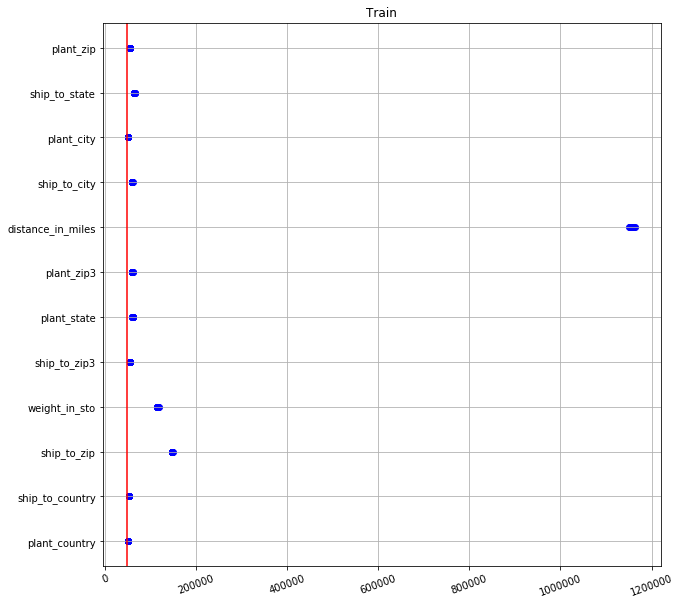

In [11]:
g = plot_perm_feat_imp(perm_mse_dict_train, train_error);
plt.title('Train');
# Indicates how model relies on different features to make predictions

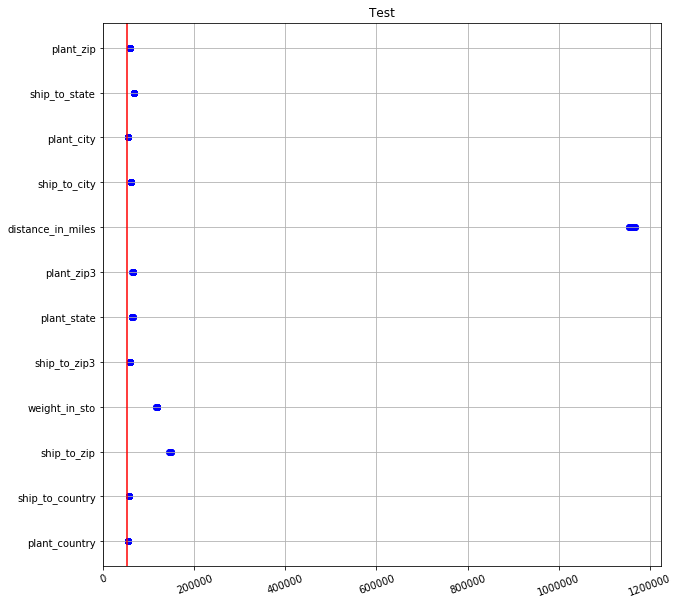

In [12]:
plot_perm_feat_imp(perm_mse_dict_test, test_error)
plt.title('Test');
# Indicates how different features are affecting true relationship